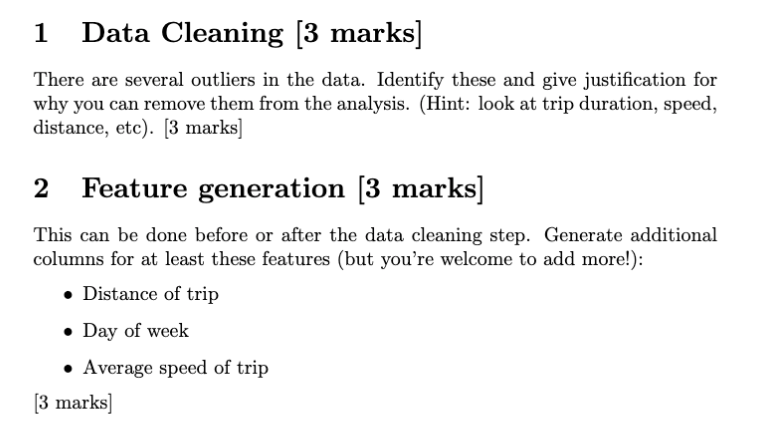

# Libraries

In [57]:
#Pandas
import pandas as pd
#Numpy
import numpy as np
#Folium
import folium
#Fiona
import fiona
#Shapely
import shapely
#Geopandas
import geopandas as gpd
#Sklearn cluster dbscan
from sklearn.cluster import DBSCAN
#Matplotlib
import matplotlib.pyplot as plt
#Seaborn
import seaborn as sns

# Loading the data

In [58]:
# Load dataset
df = pd.read_csv('nyc_taxis/nyc_taxis.csv')

In [59]:
# Info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   id                  1458644 non-null  object 
 1   vendor_id           1458644 non-null  int64  
 2   pickup_datetime     1458644 non-null  object 
 3   dropoff_datetime    1458644 non-null  object 
 4   passenger_count     1458644 non-null  int64  
 5   pickup_longitude    1458644 non-null  float64
 6   pickup_latitude     1458644 non-null  float64
 7   dropoff_longitude   1458644 non-null  float64
 8   dropoff_latitude    1458644 non-null  float64
 9   store_and_fwd_flag  1458644 non-null  object 
 10  trip_duration       1458644 non-null  int64  
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB


In [60]:
# Print the number of missing values in each column
print(df.isnull().sum())

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64


In [61]:
# Print the number of rows before cleaning
print(f"Number of rows before cleaning: {len(df)}")

Number of rows before cleaning: 1458644


# Type Conversion

In [62]:
# Convert datetime columns to datetime type
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])
df['dropoff_datetime'] = pd.to_datetime(df['dropoff_datetime'])

# Feature: Trip Duration

In [63]:
# Calculate trip duration in minutes
df['trip_duration'] = (df['dropoff_datetime'] - df['pickup_datetime']).dt.total_seconds() / 60

In [64]:
# Remove trips with zero or negative duration
df = df[df['trip_duration'] > 0]

# Distance between pickup and dropoff locations

In [65]:
# Calculate the Haversine distance between pickup and dropoff locations
def haversine(lon1, lat1, lon2, lat2):
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    km = 6367 * c
    return km

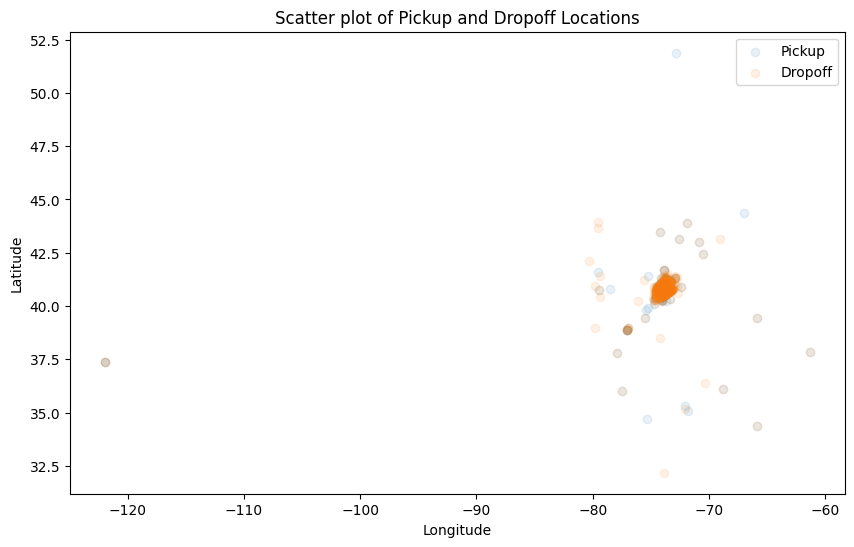

In [66]:
# Scatter plot of pickup and dropoff locations
plt.figure(figsize=(10, 6))
plt.scatter(df['pickup_longitude'], df['pickup_latitude'], alpha=0.1, label='Pickup')
plt.scatter(df['dropoff_longitude'], df['dropoff_latitude'], alpha=0.1, label='Dropoff')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Scatter plot of Pickup and Dropoff Locations')
plt.legend()
plt.show()

In [67]:
# Apply the haversine function to each row
df['trip_distance'] = df.apply(lambda row: haversine(row['pickup_longitude'], row['pickup_latitude'], row['dropoff_longitude'], row['dropoff_latitude']), axis=1)

In [68]:
# Remove trips with zero distance
df = df[df['trip_distance'] > 0]

# Feature: Average Speed

In [69]:
# Calculate average speed (km/h)
df['avg_speed'] = (df['trip_distance'] / (df['trip_duration'] / 60))

# Trip Duration

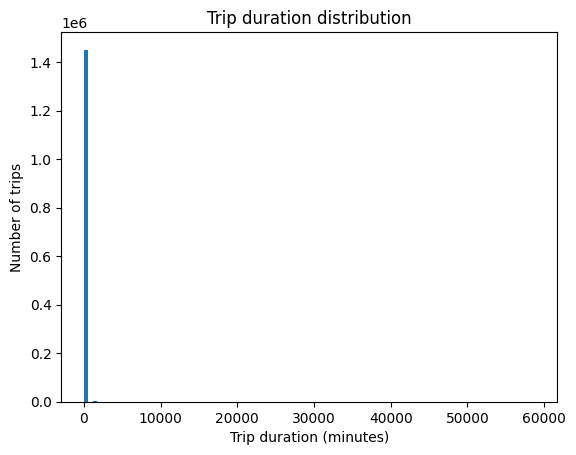

In [70]:
# Plot the trip duration, so we can see the distribution, also have a threshold of 1000 minutes
df['trip_duration'].plot(kind='hist', bins=100)
plt.xlabel('Trip duration (minutes)')
plt.ylabel('Number of trips')
plt.title('Trip duration distribution')
plt.show()

The histogram shows the distribution of trip durations. It is heavily right-skewed, meaning most of the trips are short, with the majority under 50 minutes, and a long tail representing trips with longer durations. Given this, we can make decisions on how to clean the data:

Justification for Data Cleaning
Trip Duration:

The plot shows that the majority of trips last under 50 minutes. Extremely long trips could be considered outliers because they deviate significantly from the bulk of the data.
Based on this distribution, we can remove trips with a duration exceeding 120 minutes (2 hours) as these are likely outliers and not representative of typical NYC taxi rides.
We should also remove trips with extremely short durations, such as trips lasting less than 1 minute, as they might represent errors in the data or cases where the trip was immediately canceled.
Distance:

Although not directly shown in this plot, we can assume that trips with a very small or zero distance (e.g., under 100 meters) are also erroneous and should be removed.
Speed:

After calculating the average speed of each trip, trips with unrealistic speeds, such as over 100 km/h or below 1 km/h, should be filtered out, as such speeds are unlikely for urban trips in NYC.

In [71]:
# Identify outliers based on trip duration, distance, and average speed
df = df[(df['trip_duration'] < 120) & (df['trip_duration'] > 1)]

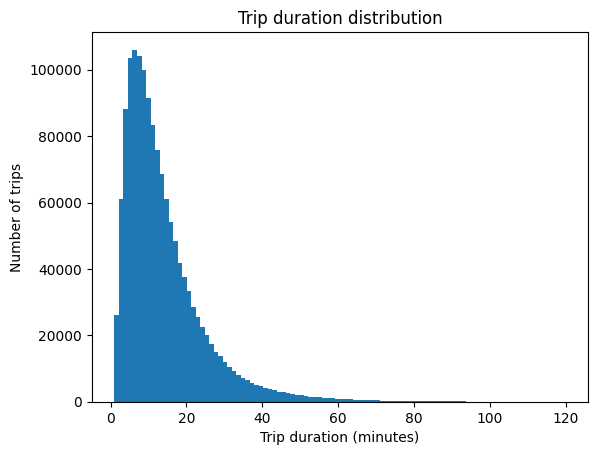

In [72]:
# Plot the new trip duration
df['trip_duration'].plot(kind='hist', bins=100)
plt.xlabel('Trip duration (minutes)')
plt.ylabel('Number of trips')
plt.title('Trip duration distribution')
plt.show()

# Trip Distance

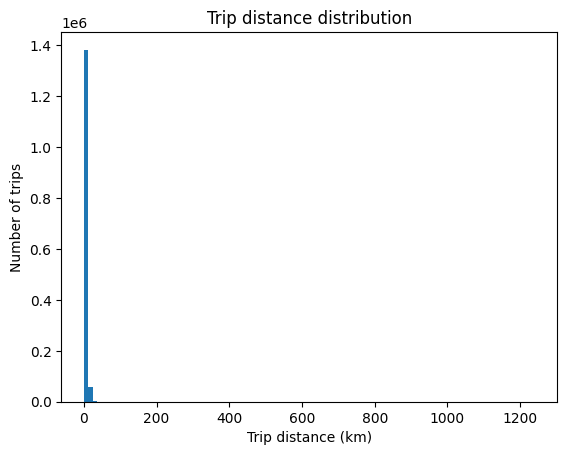

In [73]:
# Plot the trip distance, so we can see the distribution, also have a threshold
df['trip_distance'].plot(kind='hist', bins=100)
plt.xlabel('Trip distance (km)')
plt.ylabel('Number of trips')
plt.title('Trip distance distribution')
plt.show()

The histogram represents the trip distance distribution, which shows that the majority of trips are short distances (most are under 20 km), and the distribution is again right-skewed with a long tail. Let’s combine the insights from both the trip duration and trip distance histograms to refine the data cleaning strategy:

Justification for Cleaning with Trip Distance:
Trip Distance:

Similar to the trip duration distribution, this histogram indicates that most trips fall under 20 km, with a small percentage of trips extending beyond this.
We see an especially sharp spike at near-zero distances. These near-zero trips likely represent errors, or cases where the trip was canceled or incomplete. Removing trips with extremely short distances (e.g., under 100 meters) is reasonable, as they are likely erroneous.
Trips with extreme distances (e.g., beyond 25 km) are highly unlikely for typical NYC taxi trips and could be considered outliers. Based on this, we can filter trips that exceed a distance of 25 km.
Combining with Duration:

Trips with short distances but long durations might indicate potential outliers. For example, if a trip covers 1 km but takes 2 hours, that would likely be an error.
The converse also holds: a trip covering a long distance in a very short time (e.g., 100 km in 5 minutes) is unrealistic and should be flagged as an outlier.

In [74]:
# Distance threshold
df = df[(df['trip_distance'] < 25) & (df['trip_distance'] > 0.5)]

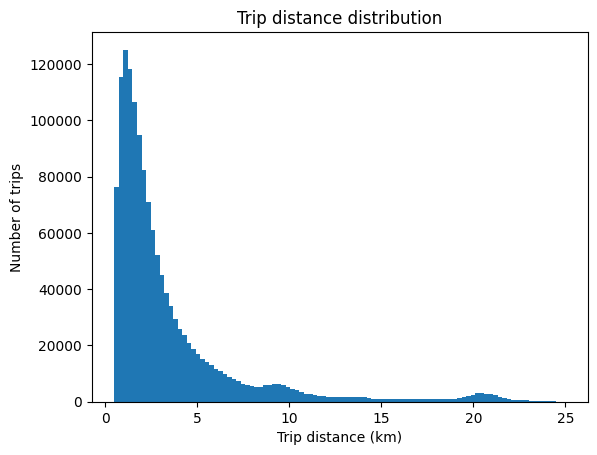

In [75]:
# Plot the new trip distance
df['trip_distance'].plot(kind='hist', bins=100)
plt.xlabel('Trip distance (km)')
plt.ylabel('Number of trips')
plt.title('Trip distance distribution')
plt.show()

# Average Speed

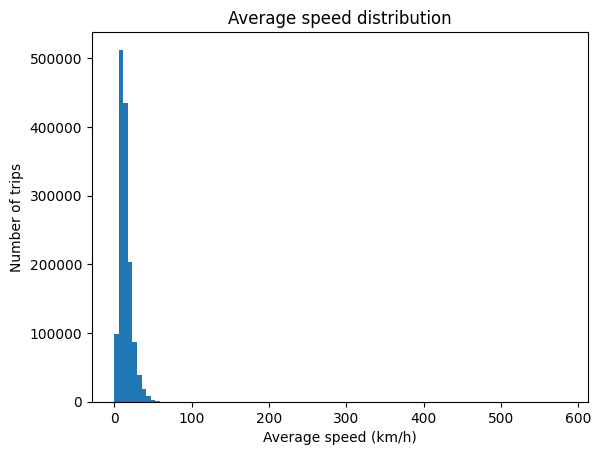

In [76]:
# Plot the average speed, so we can see the distribution, also have a threshold
df['avg_speed'].plot(kind='hist', bins=100)
plt.xlabel('Average speed (km/h)')
plt.ylabel('Number of trips')
plt.title('Average speed distribution')
plt.show()


This histogram represents the average speed distribution for taxi trips. Most trips have an average speed between 5 and 20 km/h, with a peak around 10 km/h, indicating the typical speed of taxi trips within an urban area like New York City. There’s a gradual decline in frequency as speed increases, and a very small number of trips with speeds exceeding 40 km/h, which could potentially be outliers.

Justification for Cleaning Based on Average Speed:
Typical Speeds:

The majority of taxi trips seem to have an average speed between 5 and 20 km/h, which aligns with expected urban driving conditions (due to traffic, signals, and frequent stops).
Trips with speeds under 1 km/h are highly improbable and might indicate errors in data capture or extremely short trips that skew the results.
Speeds exceeding 50 km/h seem to be extremely rare in this dataset, which suggests that such high-speed trips are potential outliers or represent trips that took place on highways.
Filtering Extremes:

Given the distribution, a reasonable upper threshold for speed could be 50 km/h to remove outliers that are far from typical urban driving speeds.
A lower threshold of 1 km/h helps to exclude trips where the speed is unrealistic for a typical trip (likely data capture issues).

In [77]:
# Average speed threshold
df = df[(df['avg_speed'] < 60) & (df['avg_speed'] > 3)]

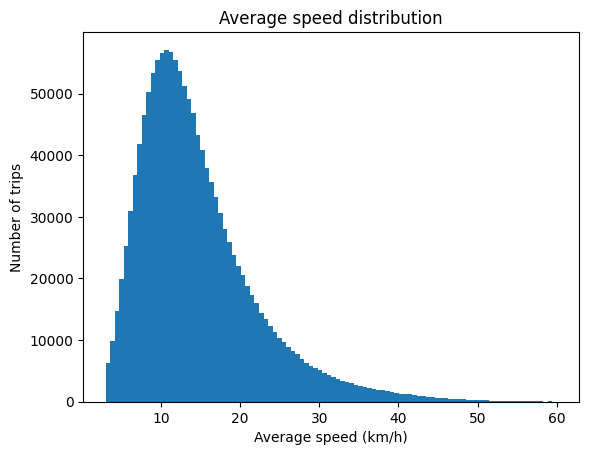

In [78]:
# Plot the new average speed
df['avg_speed'].plot(kind='hist', bins=100)
plt.xlabel('Average speed (km/h)')
plt.ylabel('Number of trips')
plt.title('Average speed distribution')
plt.show()

# Updated Scatter Plot

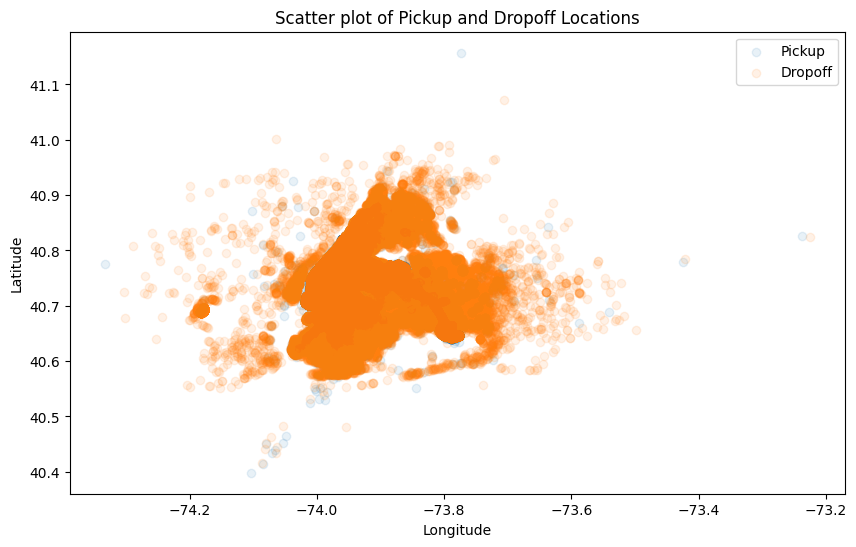

In [79]:
# Scatter plot of pickup and dropoff locations
plt.figure(figsize=(10, 6))
plt.scatter(df['pickup_longitude'], df['pickup_latitude'], alpha=0.1, label='Pickup')
plt.scatter(df['dropoff_longitude'], df['dropoff_latitude'], alpha=0.1, label='Dropoff')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Scatter plot of Pickup and Dropoff Locations')
plt.legend()
plt.show()

# Feature: Day of the Week

In [80]:
df['pickup_day'] = df['pickup_datetime'].dt.day_name()

# Feature: Hour of Day

In [81]:
df['pickup_hour'] = df['pickup_datetime'].dt.hour

# Visualize and Clean Passenger Count

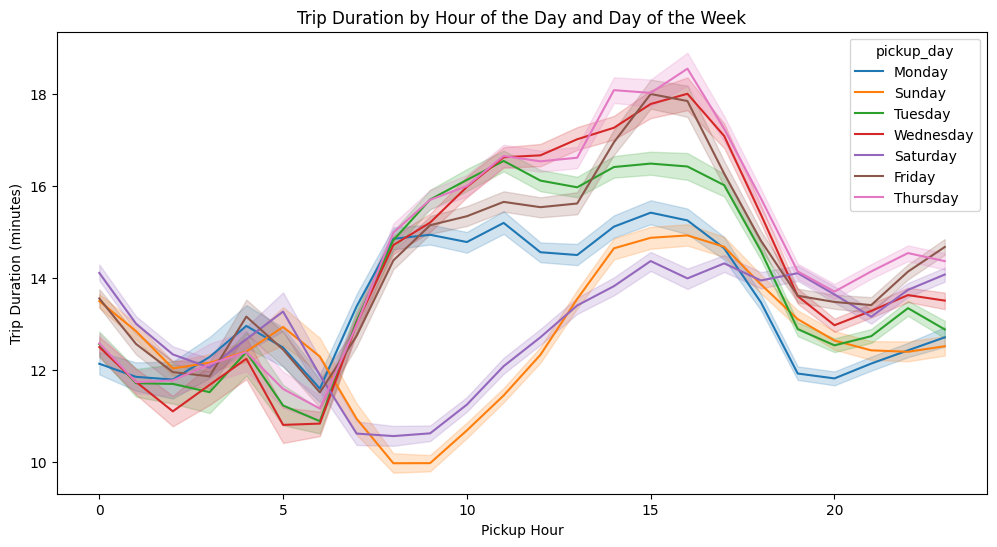

In [82]:
# Plot trip duration by day of the week and pickup time
plt.figure(figsize=(12, 6))
sns.lineplot(x='pickup_hour', y='trip_duration', hue='pickup_day', data=df)
plt.xlabel('Pickup Hour')
plt.ylabel('Trip Duration (minutes)')
plt.title('Trip Duration by Hour of the Day and Day of the Week')
plt.show()

In [83]:
df['passenger_count'] = pd.Categorical(df['passenger_count'])

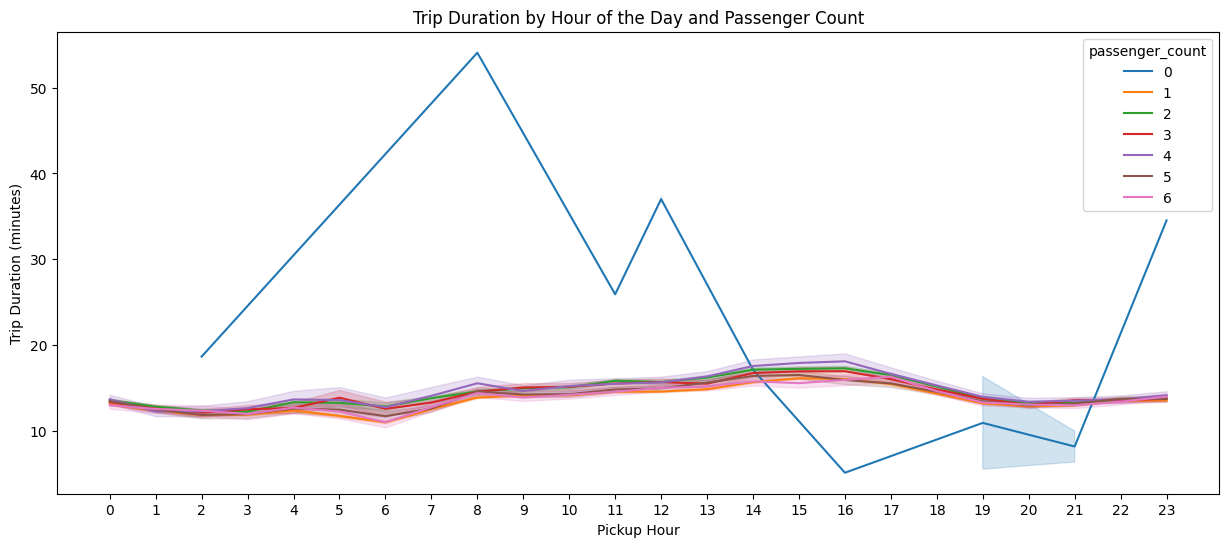

In [84]:
# Plot trip duration by passenger count and pickup time
plt.figure(figsize=(15, 6))
sns.lineplot(x='pickup_hour', y='trip_duration', hue='passenger_count', data=df)
hourly_ticks = range(0,24)
plt.xlabel('Pickup Hour')
plt.ylabel('Trip Duration (minutes)')
plt.title('Trip Duration by Hour of the Day and Passenger Count')
plt.xticks(hourly_ticks)
plt.show()

In [85]:
# Remove the peak when passenger count is 0 and greater than the trip duration of 20 minutes
df = df[(df['passenger_count'] != 0) | (df['trip_duration'] < 17)]

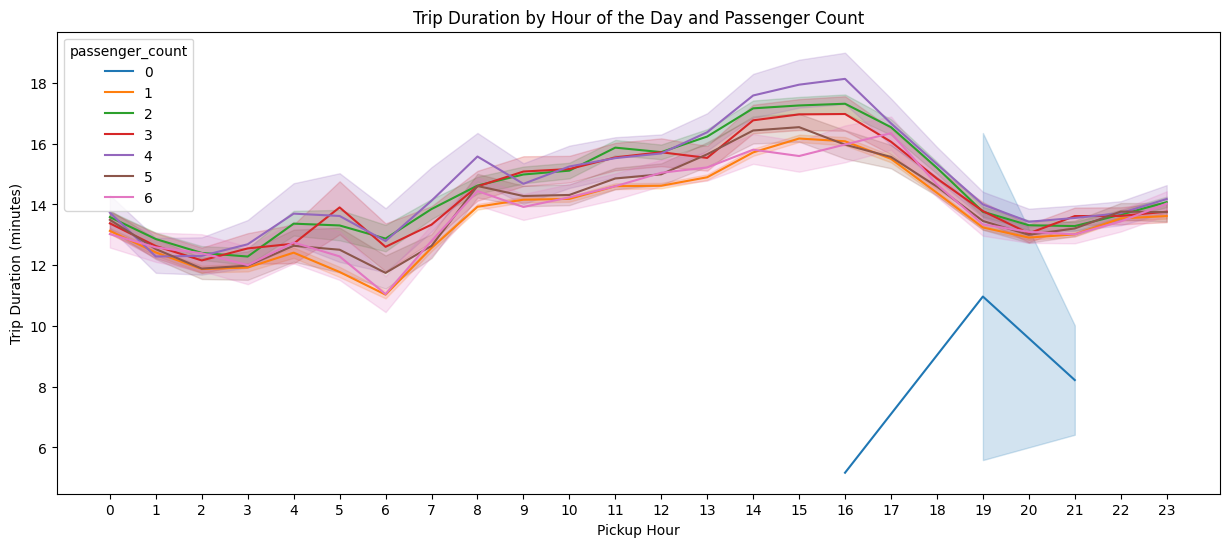

In [86]:
# Plot the cleaned data
plt.figure(figsize=(15, 6))
sns.lineplot(x='pickup_hour', y='trip_duration', hue='passenger_count', data=df)
hourly_ticks = range(0,24)
plt.xlabel('Pickup Hour')
plt.ylabel('Trip Duration (minutes)')
plt.title('Trip Duration by Hour of the Day and Passenger Count')
plt.xticks(hourly_ticks)
plt.show()

# Inspect data

In [87]:
# Print the number of rows after cleaning
print(f"Number of rows after cleaning: {len(df)}")

Number of rows after cleaning: 1399198


In [88]:
print(df.head())

          id  vendor_id     pickup_datetime    dropoff_datetime  \
0  id2875421          2 2016-03-14 17:24:55 2016-03-14 17:32:30   
1  id2377394          1 2016-06-12 00:43:35 2016-06-12 00:54:38   
2  id3858529          2 2016-01-19 11:35:24 2016-01-19 12:10:48   
3  id3504673          2 2016-04-06 19:32:31 2016-04-06 19:39:40   
4  id2181028          2 2016-03-26 13:30:55 2016-03-26 13:38:10   

  passenger_count  pickup_longitude  pickup_latitude  dropoff_longitude  \
0               1        -73.982155        40.767937         -73.964630   
1               1        -73.980415        40.738564         -73.999481   
2               1        -73.979027        40.763939         -74.005333   
3               1        -74.010040        40.719971         -74.012268   
4               1        -73.973053        40.793209         -73.972923   

   dropoff_latitude store_and_fwd_flag  trip_duration  trip_distance  \
0         40.765602                  N       7.583333       1.497580   
1 

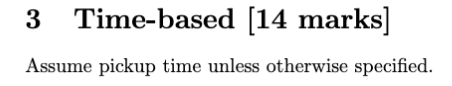

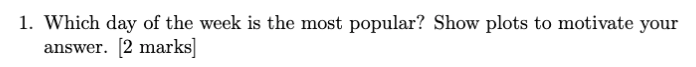

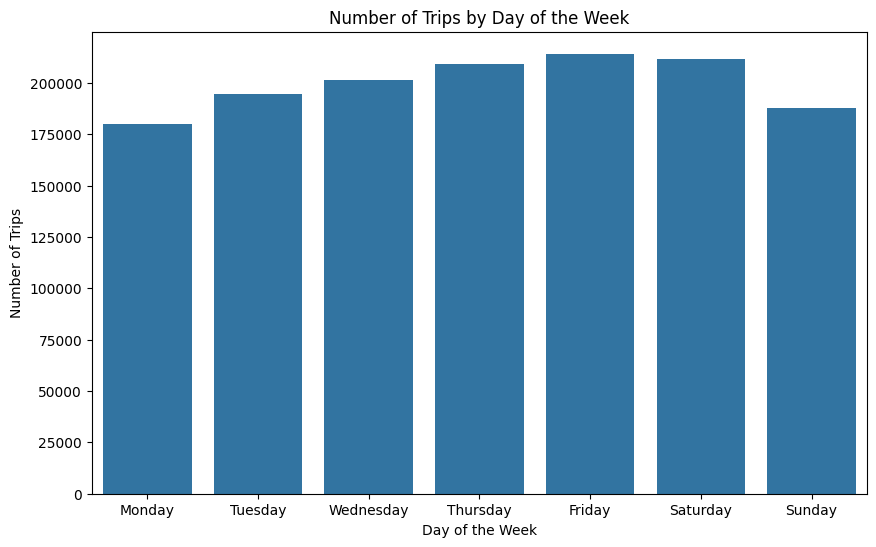

In [89]:
# Count the number of trips for each day of the week
day_counts = df['pickup_day'].value_counts()

# Plot the number of trips for each day of the week
plt.figure(figsize=(10, 6))
sns.barplot(x=day_counts.index, y=day_counts.values, order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.xlabel('Day of the Week')
plt.ylabel('Number of Trips')
plt.title('Number of Trips by Day of the Week')
plt.show()

Friday :)

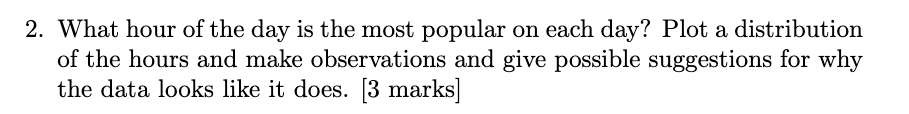

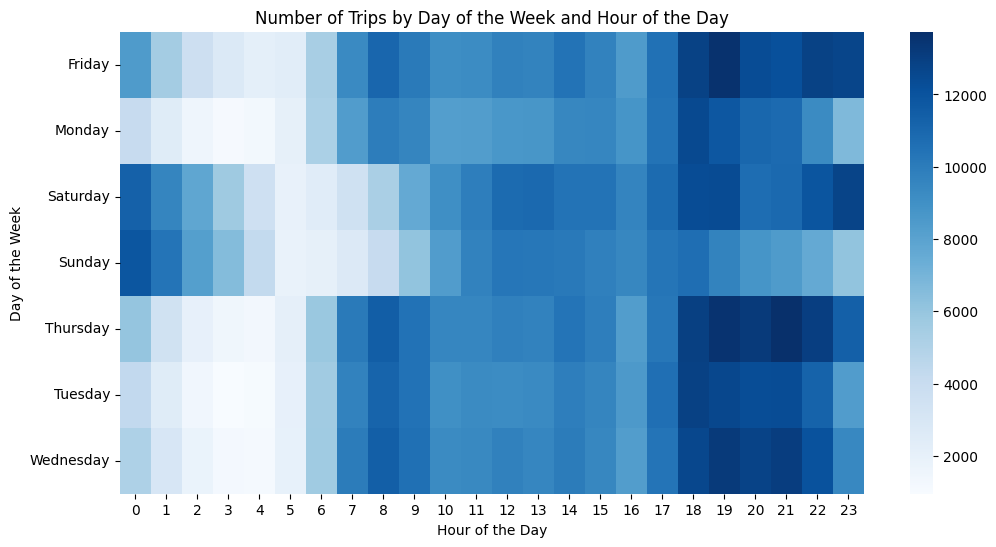

In [90]:
# Count the number of trips for each day of the week and hour of the day
day_hour_counts = df.groupby(['pickup_day', 'pickup_hour']).size().unstack()

# Plot the number of trips for each day of the week and hour of the day
plt.figure(figsize=(12, 6))
sns.heatmap(day_hour_counts, cmap='Blues')
plt.xlabel('Hour of the Day')
plt.ylabel('Day of the Week')
plt.title('Number of Trips by Day of the Week and Hour of the Day')
plt.show()

Monday - 6pm
Tuesday - 6pm
Wednesday - 7pm
Thursday - 7pm / 9pm
Friday - 7pm
Saturday - 11pm
Sunday - 12 am


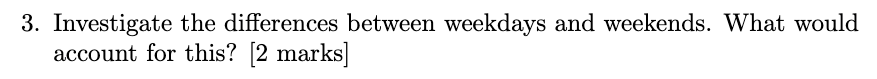

Monday to Friday is during when work ends
Saturday and Sunday is during the late hrs, late night partying

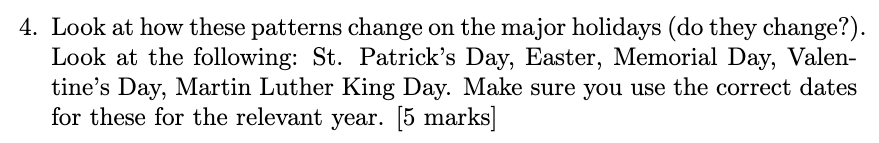

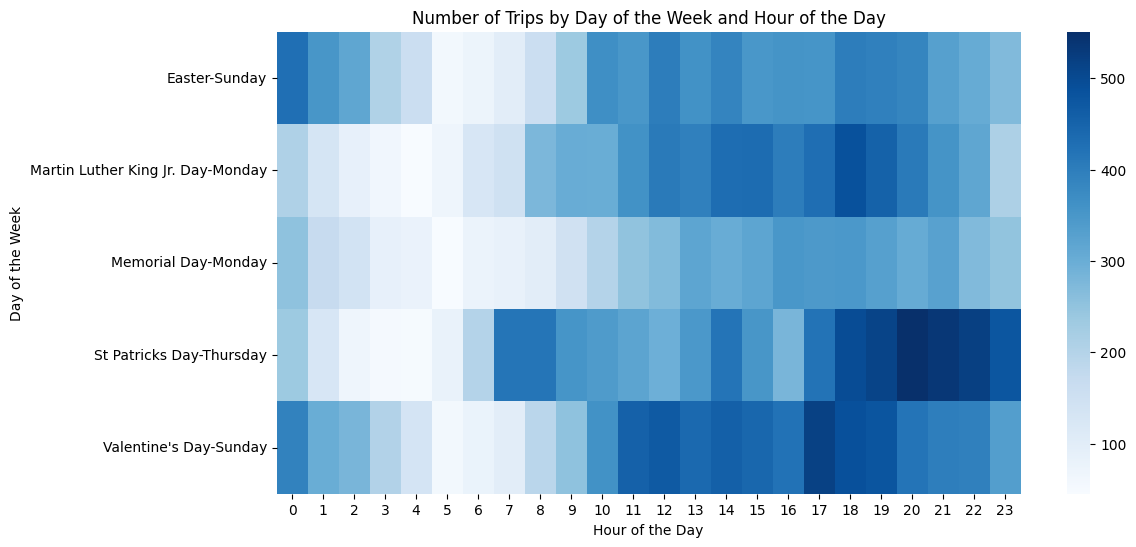

In [91]:
# St Patricks Day: 17th March
# Easter: 27th March
# Memorial Day: 30th May
# Valentine's Day: 14th February
# Martin Luther King Jr. Day: 18th January

# Define holidays for the year 2016
holidays = {
    'St Patricks Day': '2016-03-17',
    'Easter': '2016-03-27',
    'Memorial Day': '2016-05-30',
    "Valentine's Day": '2016-02-14',
    'Martin Luther King Jr. Day': '2016-01-18'
}

# Convert holiday dates to datetime objects
holidays_dt = {holiday: pd.to_datetime(date) for holiday, date in holidays.items()}

# Filter data for holidays
holiday_data = pd.DataFrame()

for holiday, date in holidays_dt.items():
    # Use .loc to avoid SettingWithCopyWarning
    filtered = df.loc[df['pickup_datetime'].dt.date == date.date()].copy()  # Make an explicit copy
    filtered['holiday'] = holiday
    holiday_data = pd.concat([holiday_data, filtered])

# Group data by holiday, day of the week, and hour of the day
day_hour_counts = holiday_data.groupby(['holiday', 'pickup_day', 'pickup_hour']).size().unstack()

# Plot all the holidays on one plot
plt.figure(figsize=(12, 6))
sns.heatmap(day_hour_counts, cmap='Blues')
plt.xlabel('Hour of the Day')
plt.ylabel('Day of the Week')
plt.title('Number of Trips by Day of the Week and Hour of the Day')
plt.show()

Thursday - 8pm (St Patricks) (No change)
Sunday - 12am (Easter) (No change)
Monday - 4pm (Memorial) (Change)
Sunday - 5pm (Valentines) (Change)
Monday - 6pm (Martin) (No change)




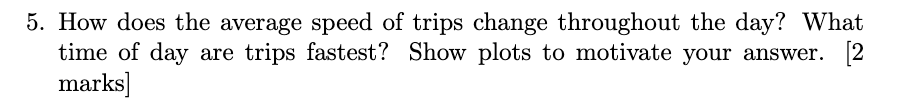

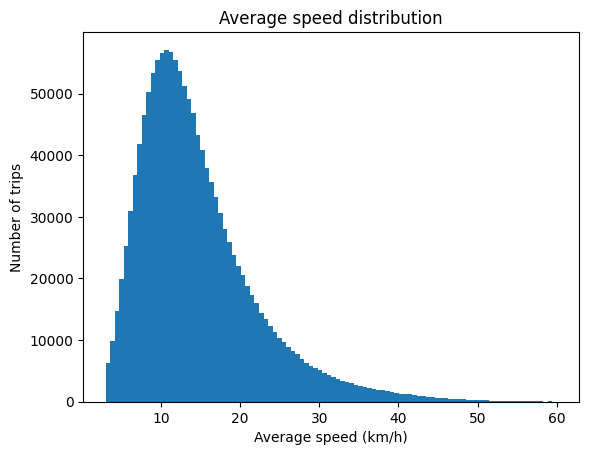

In [92]:
# Plot the new average speed
df['avg_speed'].plot(kind='hist', bins=100)
plt.xlabel('Average speed (km/h)')
plt.ylabel('Number of trips')
plt.title('Average speed distribution')
plt.show()

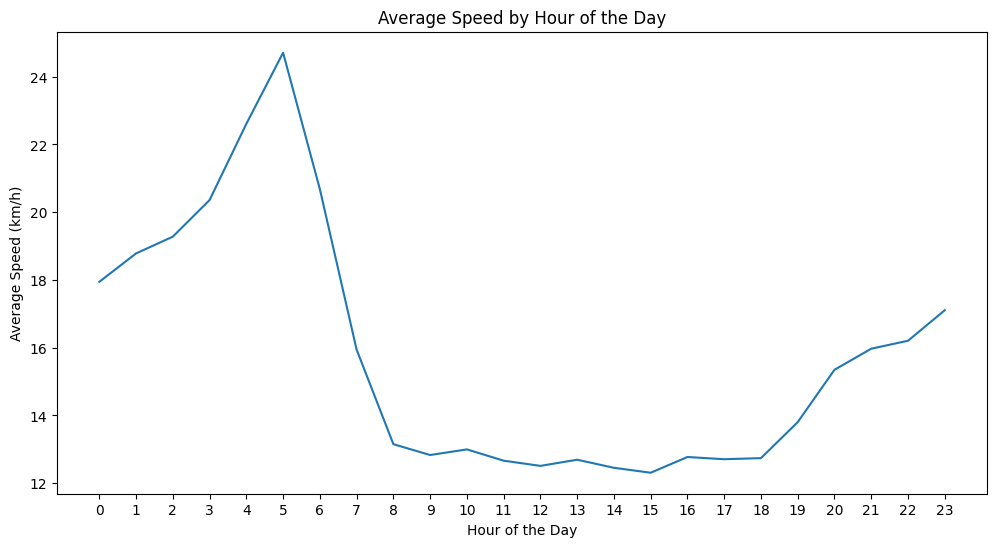

The fastest hour is 5.0:00 with an average speed of 24.71 km/h


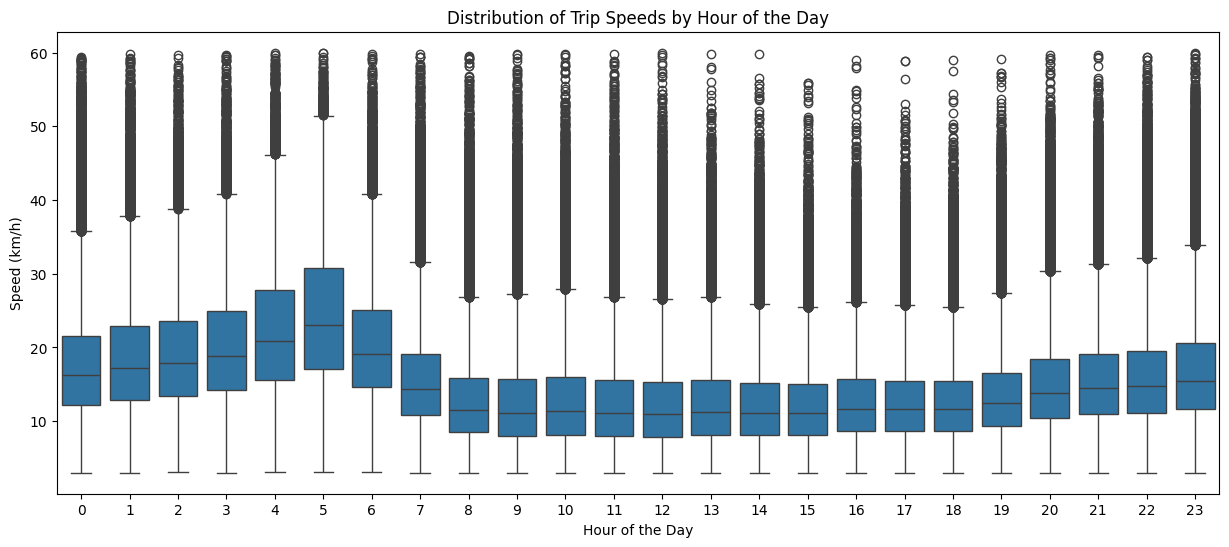

In [93]:
# Calculate average speed by hour
hourly_speed = df.groupby('pickup_hour')['avg_speed'].mean().reset_index()

# Plot average speed by hour
plt.figure(figsize=(12, 6))
sns.lineplot(x='pickup_hour', y='avg_speed', data=hourly_speed)
plt.title('Average Speed by Hour of the Day')
plt.xlabel('Hour of the Day')
plt.ylabel('Average Speed (km/h)')
plt.xticks(range(0, 24))
plt.show()

# Find the hour with the highest average speed
fastest_hour = hourly_speed.loc[hourly_speed['avg_speed'].idxmax()]
print(f"The fastest hour is {fastest_hour['pickup_hour']}:00 with an average speed of {fastest_hour['avg_speed']:.2f} km/h")

# Create a box plot to show the distribution of speeds by hour
plt.figure(figsize=(15, 6))
sns.boxplot(x='pickup_hour', y='avg_speed', data=df)
plt.title('Distribution of Trip Speeds by Hour of the Day')
plt.xlabel('Hour of the Day')
plt.ylabel('Speed (km/h)')
plt.xticks(range(0, 24))
plt.show()

Why the speed so low?
During the early parts of the morning, and late parts of the night, there is little traffic, hence the speed is greater than during the day where there would be more traffic

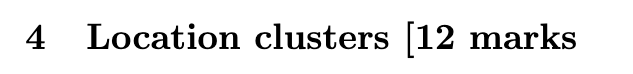

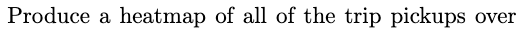

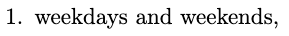

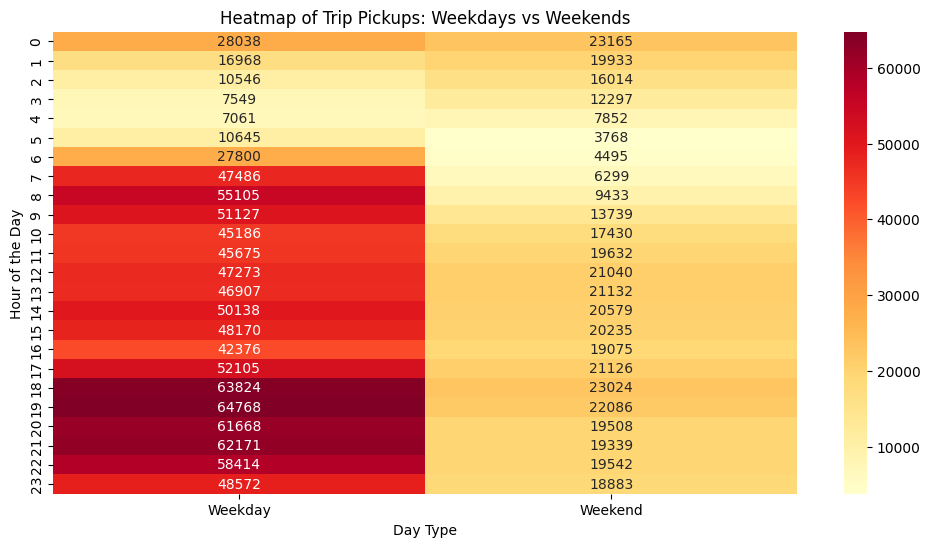

In [94]:
# Create a new column 'is_weekend' to distinguish between weekdays and weekends
df['is_weekend'] = df['pickup_day'].isin(['Saturday', 'Sunday']).map({True: 'Weekend', False: 'Weekday'})

# Group the data by 'is_weekend', 'pickup_hour', and count the trips
heatmap_data = df.groupby(['is_weekend', 'pickup_hour']).size().unstack(level=0)

# Create the heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_data, cmap='YlOrRd', annot=True, fmt='g')
plt.title('Heatmap of Trip Pickups: Weekdays vs Weekends')
plt.xlabel('Day Type')
plt.ylabel('Hour of the Day')
plt.show()

Weekday vs Weekend Patterns:
Weekdays show a much higher volume of trips overall compared to weekends.
The pattern of trip pickups differs significantly between weekdays and weekends.

Weekday Patterns:
There's a clear morning rush hour peak around 8-9 AM (hours 8-9).
An even more pronounced evening rush hour peak occurs from about 6-11 PM (hours 18-23).
The busiest time on weekdays is around 6-7 PM (hour 18), with over 60,000 pickups.

Weekend Patterns:
Weekend pickups are more evenly distributed throughout the day.
There's a gradual increase in pickups as the day progresses.
Peak times on weekends are in the late evening and early morning hours, likely due to nightlife activities.

Early Morning:
Both weekdays and weekends show increased activity in the very early morning hours (0-2 AM), possibly due to late-night returns or early morning airport runs.

Lowest Activity:
The quietest time for both weekdays and weekends is around 5 AM.
This heatmap effectively illustrates the different taxi usage patterns between weekdays and weekends, reflecting the impact of work schedules, leisure activities, and urban lifestyle on taxi demand in New York City.

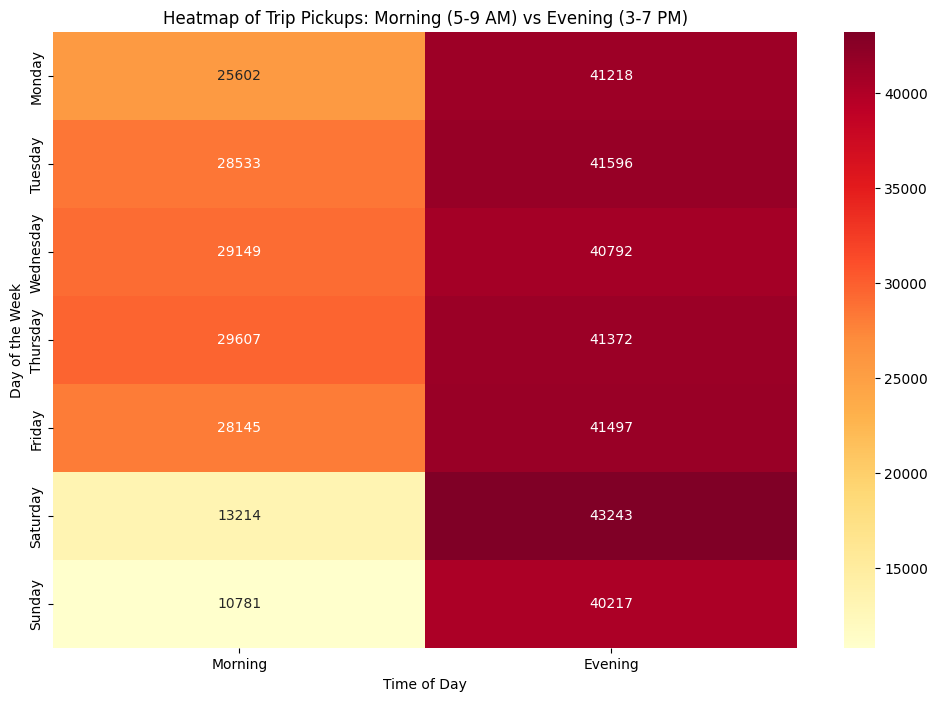

Total morning pickups (5-9 AM): 165031
Total evening pickups (3-7 PM): 289935


In [95]:
# Create a new column 'time_of_day' to distinguish between morning and evening
df['time_of_day'] = df['pickup_hour'].apply(lambda x: 'Morning' if 5 <= x < 9 else ('Evening' if 15 <= x < 19 else 'Other'))

# Group the data by 'pickup_day', 'time_of_day', and count the trips
heatmap_data = df.groupby(['pickup_day', 'time_of_day']).size().unstack(level=1)

# Reorder the days of the week
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
heatmap_data = heatmap_data.reindex(day_order)

# Create the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data[['Morning', 'Evening']], cmap='YlOrRd', annot=True, fmt='g')
plt.title('Heatmap of Trip Pickups: Morning (5-9 AM) vs Evening (3-7 PM)')
plt.xlabel('Time of Day')
plt.ylabel('Day of the Week')
plt.show()

# Print the total number of pickups for morning and evening
print("Total morning pickups (5-9 AM):", heatmap_data['Morning'].sum())
print("Total evening pickups (3-7 PM):", heatmap_data['Evening'].sum())

Overall Pattern:
Evening pickups consistently outnumber morning pickups across all days of the week.
The contrast is particularly stark on weekends.

Weekday Patterns:
Monday to Friday show similar patterns, with relatively high morning pickups and even higher evening pickups.
Thursday has the highest number of morning pickups among weekdays.
Tuesday has the highest number of evening pickups among weekdays.

Weekend Patterns:
Saturday and Sunday show a significant drop in morning pickups compared to weekdays.
However, evening pickups on weekends remain high, comparable to weekday evenings.
Sunday has the lowest morning pickups of any day.

Specific Observations:
The busiest time slot is Tuesday evening with 41,596 pickups.
The quietest time slot is Sunday morning with only 10,781 pickups.
The difference between morning and evening pickups is most pronounced on Saturdays.

Possible Interpretations:
The higher evening pickups likely reflect people returning from work, going out for dinner, or engaging in evening activities.
The drop in weekend morning pickups suggests fewer people commuting to work or having early appointments.
The consistently high evening pickups on weekends indicate active nightlife and leisure activities in the city.

This heatmap effectively illustrates the daily and weekly rhythms of taxi usage in the city, highlighting how work schedules and lifestyle patterns influence transportation needs throughout the week.

we would typically expect the number of people taking taxis to work to be similar to the number taking taxis back from work. However, the data shows a significant difference between morning and evening pickups. There are several potential reasons for this discrepancy:

Time Window Difference:
The morning window (5-9 AM) is 4 hours long, while the evening window (3-7 PM) is also 4 hours long. However, the evening window might capture more of the post-work rush than the morning window captures the pre-work rush.

Flexible Work Hours:
Many people might start work earlier than 9 AM or leave work later than 7 PM, falling outside our defined windows.

Alternative Morning Transportation:
People might be more likely to use other forms of transportation in the morning (e.g., public transit, carpooling, walking) when they have a more predictable schedule and are less rushed.

Evening Activities:
The evening pickups likely include not just people returning from work, but also those going out for dinner, entertainment, or other social activities.

Alcohol Consumption:
People who have drinks after work may be more likely to take a taxi home than they were to take one to work.


In [96]:
import numpy as np
from sklearn.cluster import DBSCAN
import folium
from folium.plugins import MarkerCluster

# Filter data for Friday 23:00 to Saturday 02:00
friday_night = df[(df['pickup_day'] == 'Friday') & (df['pickup_hour'] >= 23) | 
                  (df['pickup_day'] == 'Saturday') & (df['pickup_hour'] < 2)]

# Filter data for Thursday 17:00 to 20:00
thursday_evening = df[(df['pickup_day'] == 'Thursday') & (df['pickup_hour'].between(17, 19))]

# Combine the datasets
hotspot_data = pd.concat([friday_night, thursday_evening])

# Prepare coordinates for DBSCAN
coords = hotspot_data[['pickup_latitude', 'pickup_longitude']].values

# Set DBSCAN parameters
max_distance = 0.15  # 100 meters
min_pickups = 20
kms_per_radian = 6371.0088
epsilon = max_distance / kms_per_radian

# Apply DBSCAN
db = DBSCAN(eps=epsilon, min_samples=min_pickups, algorithm='ball_tree', metric='haversine').fit(np.radians(coords))

# Add cluster labels to the dataframe
hotspot_data['cluster'] = db.labels_

# Count the number of clusters (excluding noise points labeled as -1)
n_clusters = len(set(db.labels_)) - (1 if -1 in db.labels_ else 0)
print(f"Number of clusters found: {n_clusters}")

# Create a map centered on New York City
nyc_map = folium.Map(location=[40.7128, -74.0060], zoom_start=11)

# Add markers for each cluster
colors = ['red', 'blue', 'green', 'purple', 'orange', 'darkred', 'lightred', 'beige', 'darkblue', 'darkgreen', 'cadetblue', 'darkpurple', 'white', 'pink', 'lightblue', 'lightgreen', 'gray', 'black', 'lightgray']

for cluster in range(n_clusters):
    cluster_points = hotspot_data[hotspot_data['cluster'] == cluster]
    cluster_center = cluster_points[['pickup_latitude', 'pickup_longitude']].mean()
    folium.CircleMarker(
        location=[cluster_center['pickup_latitude'], cluster_center['pickup_longitude']],
        radius=5,
        popup=f'Cluster {cluster}',
        color=colors[cluster % len(colors)],
        fill=True,
        fill_color=colors[cluster % len(colors)]
    ).add_to(nyc_map)

# Display the map
nyc_map

Number of clusters found: 38


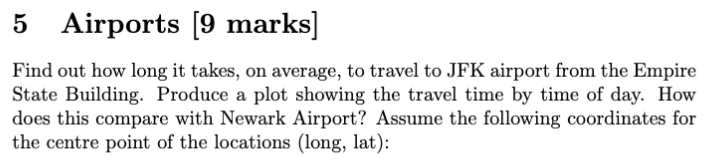

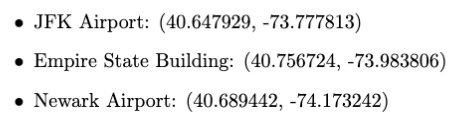

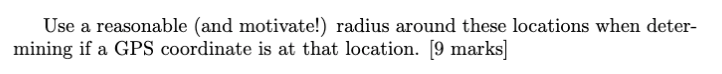

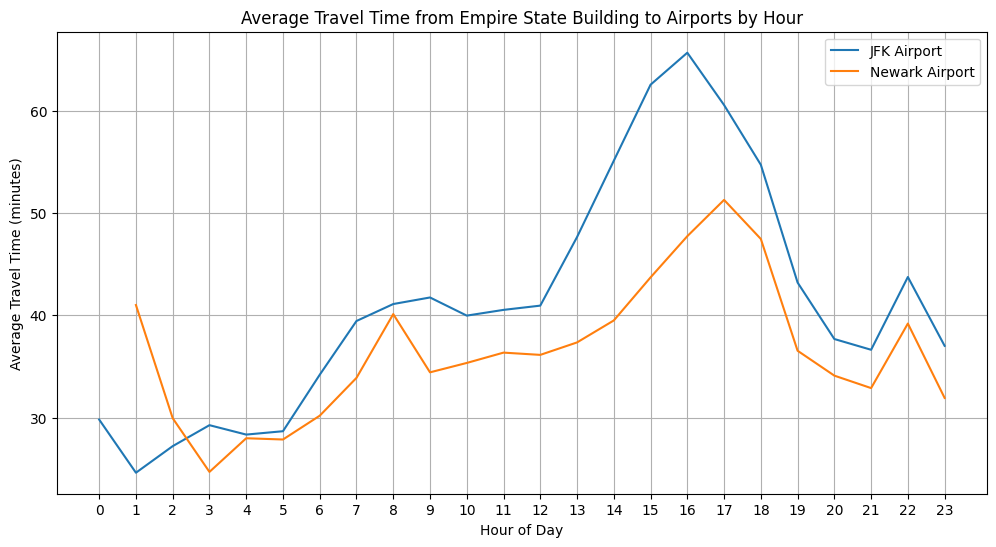

Average travel time to JFK Airport: 47.86 minutes
Average travel time to Newark Airport: 37.81 minutes


In [97]:
# Define the coordinates
empire_state = (40.756724, -73.983806)
jfk_airport = (40.647929, -73.777813)
newark_airport = (40.689442, -74.173242)

# Define a reasonable radius (in km) to consider a trip as starting/ending at these locations
radius = 1  # 1 km radius

# Use the haversine function we defined earlier
def is_within_radius(lat1, lon1, lat2, lon2, radius_km):
    distance = haversine(lon1, lat1, lon2, lat2)
    return distance <= radius_km

# Filter trips from Empire State Building to JFK Airport
empire_to_jfk = df[
    (df.apply(lambda row: is_within_radius(row['pickup_latitude'], row['pickup_longitude'], 
                                           empire_state[0], empire_state[1], radius), axis=1)) &
    (df.apply(lambda row: is_within_radius(row['dropoff_latitude'], row['dropoff_longitude'], 
                                           jfk_airport[0], jfk_airport[1], radius), axis=1))
]

# Filter trips from Empire State Building to Newark Airport
empire_to_newark = df[
    (df.apply(lambda row: is_within_radius(row['pickup_latitude'], row['pickup_longitude'], 
                                           empire_state[0], empire_state[1], radius), axis=1)) &
    (df.apply(lambda row: is_within_radius(row['dropoff_latitude'], row['dropoff_longitude'], 
                                           newark_airport[0], newark_airport[1], radius), axis=1))
]

# Calculate average travel time by hour for both airports
jfk_avg_time = empire_to_jfk.groupby('pickup_hour')['trip_duration'].mean()
newark_avg_time = empire_to_newark.groupby('pickup_hour')['trip_duration'].mean()

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(jfk_avg_time.index, jfk_avg_time.values, label='JFK Airport')
plt.plot(newark_avg_time.index, newark_avg_time.values, label='Newark Airport')
plt.xlabel('Hour of Day')
plt.ylabel('Average Travel Time (minutes)')
plt.title('Average Travel Time from Empire State Building to Airports by Hour')
plt.legend()
plt.xticks(range(0, 24))
plt.grid(True)
plt.show()

# Print overall average travel times
print(f"Average travel time to JFK Airport: {empire_to_jfk['trip_duration'].mean():.2f} minutes")
print(f"Average travel time to Newark Airport: {empire_to_newark['trip_duration'].mean():.2f} minutes")

Overall Comparison:
JFK Airport generally has longer travel times compared to Newark Airport across most hours of the day.
The average travel time to JFK ranges roughly from 25 to 67 minutes, while for Newark it's about 25 to 52 minutes.

Time of Day Patterns:
Both airports show similar patterns of travel time fluctuations throughout the day.
Early morning hours (1-5 AM) have the shortest travel times for both airports.
Travel times increase significantly during morning rush hour (6-9 AM).
The longest travel times occur during evening rush hour, peaking around 5-7 PM (17-19 hours).
Peak Travel Times:
JFK: The peak travel time is around 5-6 PM (17-18 hours), reaching about 67 minutes.
Newark: The peak is also around 5-6 PM, but lower at about 52 minutes.

Off-Peak Travel Times:
Both airports have the shortest travel times in the early morning hours, around 2-4 AM.
JFK's shortest time is about 25 minutes, while Newark's is about 26 minutes.

Consistency:
Newark shows slightly more consistent travel times throughout the day, with less extreme peaks and troughs compared to JFK.

Afternoon Increase:
Both airports show a gradual increase in travel time starting from around 1 PM (13 hours), leading up to the evening peak.

In conclusion, traveling to Newark Airport from the Empire State Building is generally faster than traveling to JFK Airport, especially during peak hours. The difference is most pronounced during the evening rush hour, where JFK can take up to 15 minutes longer. However, both airports follow similar daily patterns in travel time fluctuations, with the fastest trips possible in the early morning hours and the longest during the evening rush hour. The choice between airports might depend on the time of day and the traveler's tolerance for longer travel times, with Newark being the faster option in most cases.

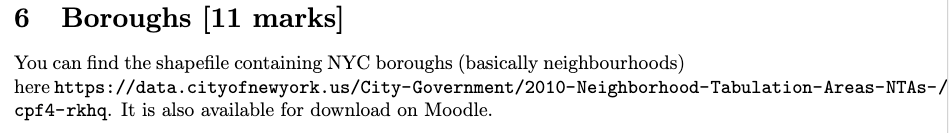

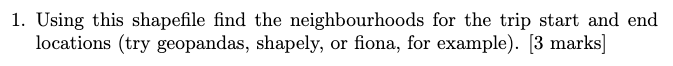

In [98]:
import geopandas as gpd
from shapely.geometry import Point

# Load the NYC boroughs shapefile
nyc_boroughs = gpd.read_file('2010 Neighborhood Tabulation Areas (NTAs)/geo_export_01b7a854-00a9-4a17-93fc-4e53946a61f0.shp')

# Print the column names to identify the neighborhood column
print("Columns in the shapefile:", nyc_boroughs.columns)

# Set the neighborhood column name
neighborhood_column = 'ntaname'

# Convert the taxi trip data to a GeoDataFrame
geometry_pickup = [Point(xy) for xy in zip(df['pickup_longitude'], df['pickup_latitude'])]
geometry_dropoff = [Point(xy) for xy in zip(df['dropoff_longitude'], df['dropoff_latitude'])]

gdf_pickup = gpd.GeoDataFrame(df, geometry=geometry_pickup, crs="EPSG:4326")
gdf_dropoff = gpd.GeoDataFrame(df, geometry=geometry_dropoff, crs="EPSG:4326")

# Ensure the CRS of both datasets match
nyc_boroughs = nyc_boroughs.to_crs(gdf_pickup.crs)

# Perform spatial join to find the neighborhood for pickup and dropoff locations
gdf_pickup = gpd.sjoin(gdf_pickup, nyc_boroughs[[neighborhood_column, 'geometry']], how="left", op="within")
gdf_dropoff = gpd.sjoin(gdf_dropoff, nyc_boroughs[[neighborhood_column, 'geometry']], how="left", op="within")

# Rename the columns
gdf_pickup = gdf_pickup.rename(columns={neighborhood_column: 'pickup_neighborhood'})
gdf_dropoff = gdf_dropoff.rename(columns={neighborhood_column: 'dropoff_neighborhood'})

# Merge the results back to the original dataframe
df['pickup_neighborhood'] = gdf_pickup['pickup_neighborhood']
df['dropoff_neighborhood'] = gdf_dropoff['dropoff_neighborhood']

# Display the first few rows to verify the results
print(df[['pickup_neighborhood', 'dropoff_neighborhood']].head())

# Check for any null values
print("\nNull values in pickup_neighborhood:", df['pickup_neighborhood'].isnull().sum())
print("Null values in dropoff_neighborhood:", df['dropoff_neighborhood'].isnull().sum())

Columns in the shapefile: Index(['boro_code', 'boro_name', 'county_fip', 'ntacode', 'ntaname',
       'shape_area', 'shape_leng', 'geometry'],
      dtype='object')


/Users/sayfullahjumoorty/miniconda3/envs/general/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3490: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
/Users/sayfullahjumoorty/miniconda3/envs/general/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3490: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


                      pickup_neighborhood               dropoff_neighborhood
0                          Lincoln Square      Upper East Side-Carnegie Hill
1                    Murray Hill-Kips Bay                       West Village
2                   Midtown-Midtown South  Battery Park City-Lower Manhattan
3  SoHo-TriBeCa-Civic Center-Little Italy  Battery Park City-Lower Manhattan
4                         Upper West Side                    Upper West Side

Null values in pickup_neighborhood: 311
Null values in dropoff_neighborhood: 4683


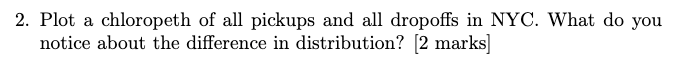

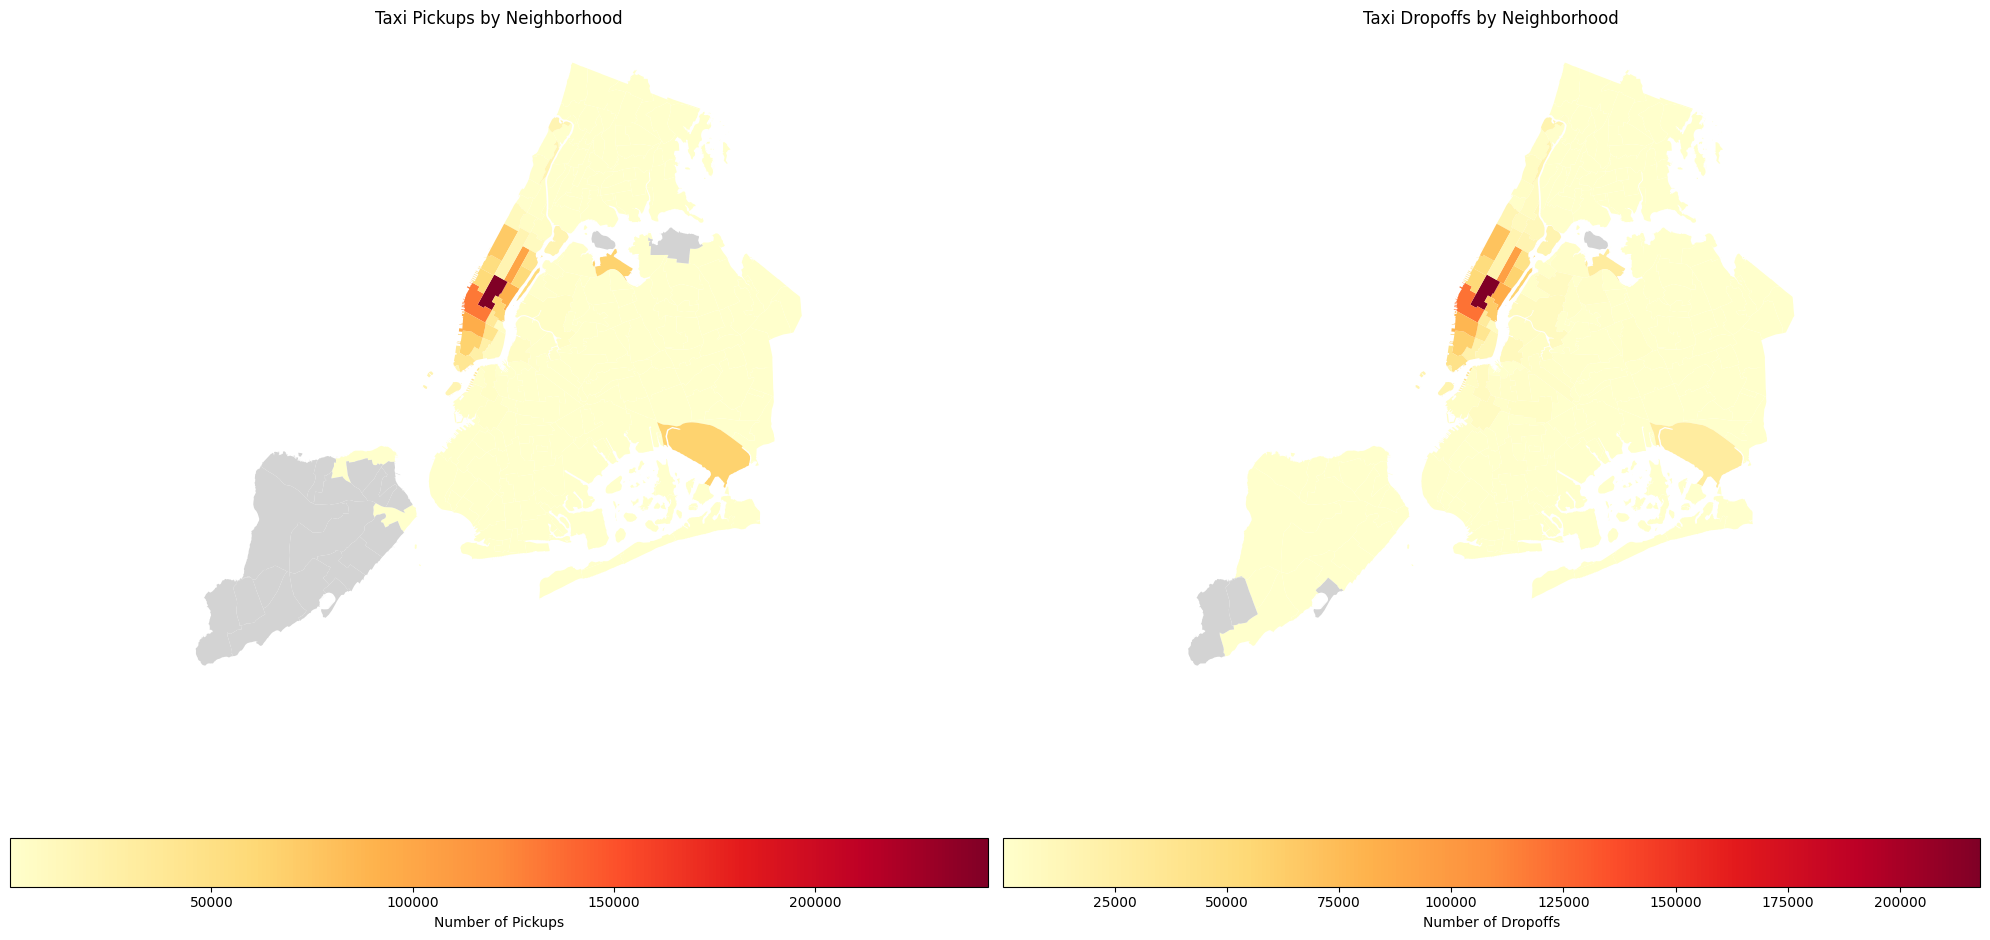

Top 5 Pickup Neighborhoods:
pickup_neighborhood
Midtown-Midtown South                         242744
Hudson Yards-Chelsea-Flatiron-Union Square    131363
Upper East Side-Carnegie Hill                 101947
West Village                                   94984
Turtle Bay-East Midtown                        92904
Name: count, dtype: int64

Top 5 Dropoff Neighborhoods:
dropoff_neighborhood
Midtown-Midtown South                         217825
Hudson Yards-Chelsea-Flatiron-Union Square    120584
Upper East Side-Carnegie Hill                  95135
Turtle Bay-East Midtown                        86049
West Village                                   78623
Name: count, dtype: int64


In [99]:
import matplotlib.pyplot as plt

# Count pickups and dropoffs by neighborhood
pickup_counts = df['pickup_neighborhood'].value_counts()
dropoff_counts = df['dropoff_neighborhood'].value_counts()

# Add these counts to the nyc_boroughs GeoDataFrame
nyc_boroughs['pickup_count'] = nyc_boroughs[neighborhood_column].map(pickup_counts)
nyc_boroughs['dropoff_count'] = nyc_boroughs[neighborhood_column].map(dropoff_counts)

# Create the chloropleth maps
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

# Pickup map
nyc_boroughs.plot(column='pickup_count', ax=ax1, legend=True, 
                  legend_kwds={'label': 'Number of Pickups', 'orientation': 'horizontal'},
                  cmap='YlOrRd', missing_kwds={'color': 'lightgrey'})
ax1.set_title('Taxi Pickups by Neighborhood')
ax1.axis('off')

# Dropoff map
nyc_boroughs.plot(column='dropoff_count', ax=ax2, legend=True, 
                  legend_kwds={'label': 'Number of Dropoffs', 'orientation': 'horizontal'},
                  cmap='YlOrRd', missing_kwds={'color': 'lightgrey'})
ax2.set_title('Taxi Dropoffs by Neighborhood')
ax2.axis('off')

plt.tight_layout()
plt.show()

# Print the top 5 neighborhoods for pickups and dropoffs
print("Top 5 Pickup Neighborhoods:")
print(pickup_counts.head())
print("\nTop 5 Dropoff Neighborhoods:")
print(dropoff_counts.head())


1. Concentration in Manhattan: Both pickups and dropoffs are heavily concentrated in Manhattan, particularly in Midtown and Lower Manhattan. This is evident from the darker colors in these areas on both maps.

2. Intensity of pickups vs dropoffs: The pickup map shows more intense colors (darker reds) in central areas compared to the dropoff map, suggesting a higher concentration of pickups in these central locations.

3. Top neighborhoods: While the top 5 neighborhoods for pickups and dropoffs are the same, the numbers are consistently higher for pickups than dropoffs in these areas. For example, Midtown-Midtown South has 242,744 pickups but 217,825 dropoffs.

4. Outer boroughs: The outer boroughs (Brooklyn, Queens, Bronx, and Staten Island) show lighter colors in both maps, indicating fewer taxi trips. However, there seems to be slightly more activity in these areas for dropoffs compared to pickups, particularly in parts of Brooklyn and Queens.

5. Specific hotspots: Certain neighborhoods like Hudson Yards-Chelsea-Flatiron-Union Square and Upper East Side-Carnegie Hill show up as hotspots in both maps, but with higher intensity for pickups.

6. Spread of dropoffs: The dropoff map shows a slightly more even distribution across neighborhoods compared to the pickup map, suggesting that while people tend to hail taxis from central locations, they're dropped off in a wider range of areas.

7. Airport patterns: While not explicitly labeled, we can infer that the small hotspots in Queens (likely JFK airport) and possibly in Brooklyn or Queens (potentially LaGuardia airport) show more intense colors for dropoffs than pickups, suggesting more people take taxis to airports than from them.

These differences in distribution likely reflect the city's layout, with business and tourist areas generating more pickups, while residential areas and transportation hubs see more dropoffs. The pattern suggests that taxis play a significant role in bringing people into central Manhattan from other areas, but the return trips are more dispersed.

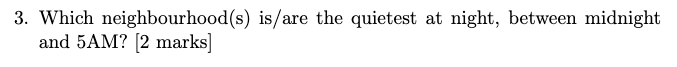

In [100]:
# Convert pickup_datetime to datetime if it's not already
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])

# Create a new column for hour
df['pickup_hour'] = df['pickup_datetime'].dt.hour

# Filter for nighttime pickups (between midnight and 5 AM)
night_pickups = df[(df['pickup_hour'] >= 0) & (df['pickup_hour'] < 5)]

# Group by neighborhood and count pickups
night_pickup_counts = night_pickups['pickup_neighborhood'].value_counts()

# Sort in ascending order (quietest first)
quietest_neighborhoods = night_pickup_counts.sort_values()

# Find the minimum count
min_count = quietest_neighborhoods.min()

# Get all neighborhoods with the minimum count
quietest = quietest_neighborhoods[quietest_neighborhoods == min_count]

print("\nThe quietest neighborhood(s) at night:")
print(quietest)


The quietest neighborhood(s) at night:
pickup_neighborhood
Co-op City                                         1
Allerton-Pelham Gardens                            1
Lindenwood-Howard Beach                            1
Ocean Parkway South                                1
Bellerose                                          1
Van Cortlandt Village                              1
Ozone Park                                         1
Starrett City                                      1
Auburndale                                         1
Pelham Bay-Country Club-City Island                1
West Brighton                                      1
West New Brighton-New Brighton-St. George          1
East Flushing                                      1
Soundview-Castle Hill-Clason Point-Harding Park    1
Glen Oaks-Floral Park-New Hyde Park                1
Rosedale                                           1
Gravesend                                          1
Oakland Gardens                        

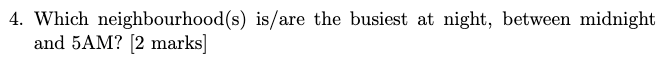

In [101]:
# Convert pickup_datetime to datetime if it's not already
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])

# Create a new column for hour
df['pickup_hour'] = df['pickup_datetime'].dt.hour

# Filter for nighttime pickups (between midnight and 5 AM)
night_pickups = df[(df['pickup_hour'] >= 0) & (df['pickup_hour'] < 5)]

# Group by neighborhood and count pickups
night_pickup_counts = night_pickups['pickup_neighborhood'].value_counts()

# Sort in descending order (busiest first)
busiest_neighborhoods = night_pickup_counts.sort_values(ascending=False)

# Display the top 10 busiest neighborhoods
print("Top 10 busiest neighborhoods at night (midnight to 5 AM):")
print(busiest_neighborhoods.head(10))

Top 10 busiest neighborhoods at night (midnight to 5 AM):
pickup_neighborhood
Midtown-Midtown South                         22688
West Village                                  18008
Hudson Yards-Chelsea-Flatiron-Union Square    15997
East Village                                  12344
Chinatown                                      9390
SoHo-TriBeCa-Civic Center-Little Italy         8420
Clinton                                        8419
Turtle Bay-East Midtown                        6329
Murray Hill-Kips Bay                           5171
Gramercy                                       4084
Name: count, dtype: int64
